Retrieves images from "raw_imgs" folder and stores them in "full_imgs". Retrieves spreadsheet listing VOIs and stores them in text file.

TODO: function to read existing vois, drop one class, then load the class back in. Requires that drm.load_imgs write to a DataFrame rather than an array

In [11]:
import config
import dr_methods as drm
import helper_fxns as hf
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import voi_methods as vm
%matplotlib inline

In [13]:
importlib.reload(config)
importlib.reload(hf)
importlib.reload(vm)
importlib.reload(drm)
C = config.Config()

# Read Run Stats

In [74]:
import re
import operator

df = pd.read_csv(C.run_stats_path)

df = df.dropna(subset=['misclassified_test'])
df = df.loc[:,['misclassified_test','misclassified_train']]
#df = df.dropna()
#b = a.iloc[0]['y_pred_raw']
#b = hf.str_to_lists(b)

mis_test = df['misclassified_train'].values
#mis_test = df['misclassified_test'].values

mis_test = ''.join(mis_test)
mis_test = mis_test.replace(' ','')
mis_test = mis_test.replace("'","")
mis_test = re.sub(r'\]\[', ',', mis_test)
mis_test = mis_test.replace("[","")
mis_test = mis_test.replace("]","")

mis_test = mis_test.split(',')

unique, counts = np.unique(mis_test, return_counts=True)

x = dict(zip(unique, counts))

sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
np.save()

In [95]:
df = pd.read_csv(C.run_stats_path)
df = df[(df['test_num'] == '10') & (~df['time_dist']) & (df['steps_per_epoch'] == 750) & (df['timestamp'] < 1515210355)]

In [78]:
df.columns

Index(['n', 'n_art', 'steps_per_epoch', 'epochs', 'training_fraction',
       'test_num', 'augment_factor', 'non_imaging_inputs', 'kernel_size',
       'conv_filters', 'padding', 'dropout', 'time_dist', 'dilation',
       'dense_units', 'acc6cls', 'acc3cls', 'time_elapsed(s)', 'loss_hist',
       'hcc', 'cholangio', 'colorectal', 'cyst', 'hemangioma', 'fnh',
       'confusion_matrix', 'timestamp', 'misclassified_test',
       'misclassified_train', 'model_num', 'y_true', 'y_pred_raw', 'z_test'],
      dtype='object')

In [90]:
a = [1-x.count("npy")/434 for x in df['misclassified_train'].values]

In [83]:
df['misclassified_train'].values

array(["['12678910_2.npy', 'E100207768_0.npy']", '[]',
       "['E103776968_0.npy', '12678910_2.npy', 'E100815255_1.npy']",
       "['12831275_1.npy', 'E101516755_0.npy', '12975280_0.npy']",
       "['E100207768_0.npy']", "['E100987314_0.npy']",
       "['E101166449_0.npy', 'E101083458_4.npy']", '[]', '[]',
       "['E106200941_1.npy']", '[]', "['12874178_0.npy']", '[]', '[]',
       "['12919851_1.npy']", '[]', '[]',
       "['12799652_4.npy', '13031955_0.npy']", "['E104824034_0.npy']",
       '[]'], dtype=object)

In [100]:
np.mean(df['acc6cls'].values)

0.8891666665500001

In [52]:
cms = df['confusion_matrix'].values

cms = ''.join(cms)

ret = hf.str_to_lists(cms, dtype=int)

supercm = ret

supercm = [supercm[rownum:rownum+6] for rownum in range(0,len(supercm),6)]

supercm = np.array(supercm)

cm_sum = np.empty((6,6))

for i in range(6):
    for j in range(6):
        cm_sum[i,j] = np.sum(supercm[:,i,j])

for i in range(6):
    for j in range(6):
        print(cm_sum[j,i],end='\t')
    print()

In [97]:
truths = df['y_true'].values
truths = ''.join(truths)
truths = hf.str_to_lists(truths, dtype=int)
truths = np.array(truths)

predictions = df['y_pred_raw'].values
predictions = ''.join(predictions)
predictions = hf.str_to_lists(predictions, dtype=float)
predictions = [predictions[rownum:rownum+60] for rownum in range(0,len(predictions),60)]
predictions = np.array(predictions)

In [98]:
hcc_thresh = []
nonhcc_thresh = []
thresh_dict = {}

for run_num in range(20):
    for lesion_num in range(60):
        if truths[run_num, lesion_num] == C.classes_to_include.index('hcc'):
            hcc_thresh.append(predictions[run_num, lesion_num, 0])
            thresh_dict[predictions[run_num, lesion_num, 0]] = 'hcc'
        else:
            nonhcc_thresh.append(predictions[run_num, lesion_num, 0])
            thresh_dict[predictions[run_num, lesion_num, 0]] = 'non-hcc'

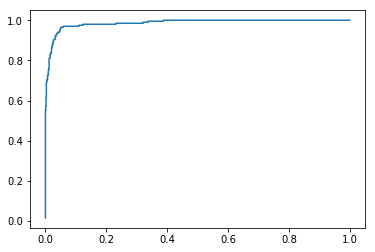

In [109]:
TPR = [200/200]
FPR = [1000/1000]

hcc_correct = 200
hcc_wrong = 1000
for key in sorted(thresh_dict):
    if thresh_dict[key] == 'hcc':
        hcc_correct -= 1
    else:
        hcc_wrong -= 1
    TPR.append(hcc_correct/200)
    FPR.append(hcc_wrong/1000)

plt.plot(FPR, TPR)

In [182]:
AUC = sum([(FPR[i+1]-FPR[i])*TPR[i] for i in range(len(FPR)-1)])

In [183]:
AUC

0.9862449999999985

# Reload images and VOIs

In [ ]:
drm.load_vois_all(C)

In [234]:
for cls in C.classes_to_include:
    if not os.path.exists(C.full_img_dir + "\\" + cls):
        os.makedirs(C.full_img_dir + "\\" + cls)
    if not os.path.exists(C.orig_dir + cls):
        os.makedirs(C.orig_dir + cls)
    if not os.path.exists(C.aug_dir + cls):
        os.makedirs(C.aug_dir + cls)
    if not os.path.exists(C.crops_dir + cls):
        os.makedirs(C.crops_dir + cls)

In [ ]:
voi_dfs = init_voi_dfs()

In [ ]:
#dims_df = pd.DataFrame(columns = ["AccNum", "x", "y", "z"])
dims_df = pd.read_csv(C.dims_df_path)
voi_df_art = pd.DataFrame(columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls",
                                     "flipz", "real_dx", "real_dy", "real_dz", "id", "lesion_num"])
voi_df_ven = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_df_eq = pd.DataFrame(columns = ["id", "x1", "x2", "y1", "y2", "z1", "z2"]) #voi_df_ven only contains entries where manually specified
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]

In [5]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
voi_dfs = [voi_df_art, voi_df_ven, voi_df_eq]
dims_df = pd.read_csv(C.dims_df_path)
intensity_df = pd.read_csv(C.int_df_path)
#intensity_df = drm.get_intensities(C, cls="hcc", acc_num='E106046622')

In [ ]:
intensity_df = drm.get_intensities(C, cls="hemangioma", acc_num='13138944')

In [ ]:
patient_info_df = pd.DataFrame(columns = ["MRN", "Sex", "AccNum", "AgeAtImaging", "cls"])
for i in [C.sheetnames.index(x) for x in ['HCC']]:
    #drm.check_folders(img_dirs[i], xls_name, sheetnames[i], C)
    #dims_df = drm.load_imgs(img_dirs[i], cls_names[i], xls_name, sheetnames[i], dims_df, C)
    #voi_dfs = drm.load_vois_batch(cls_names[i], voi_dfs, dims_df, C)#, acc_nums=['E104764948','E106046622'])
    #intensity_df = drm.get_intensities(C, cls=cls_names[i], acc_num='E106046622')
    patient_info_df = drm.load_patient_info("Z:\\"+C.img_dirs[i], C.cls_names[i], C.sheetnames[i], patient_info_df, C,
                                           acc_nums=['12916368'])
patient_info_df.to_csv('Z:\\patient_info_missing.csv', index=False)

In [187]:
#voi_df_art, voi_df_ven, voi_df_eq = voi_dfs
voi_df_art.to_csv(C.art_voi_path, index=False)
voi_df_ven.to_csv(C.ven_voi_path, index=False)
voi_df_eq.to_csv(C.eq_voi_path, index=False)

In [ ]:
dims_df.to_csv(C.dims_df_path, index=False)

In [112]:
#drm.delete_imgs(['12916368', 'E102556695'], 'hcc', C)
#drm.delete_imgs(0, cls, C, xls_name, sheetname)
drm.reload_imgs(["13092966"], "hcc", C, update_intensities=False)


Loading DCM for ['13092966']
Found elastix version: 4.800 in 'c:\\program files\\elastix_v4.8\\elastix.exe'
.Overall time: 352.06467723846436

Loading DCM for ['13092966']
Z:\optn5b\13092966\T1_AP [WinError 3] The system cannot find the path specified: 'Z:\\optn5b\\13092966\\T1_AP'


In [ ]:
vm.xref_dirs_with_excel(C)

In [107]:
Z_reader = ['12888679_2.npy', 'E101218384_5.npy', '12324408_0.npy', '12975280_0.npy', 'E100962970_0.npy', 'E101083458_1.npy', 'E105311123_0.npy', 'E104697262_0.npy', 'E100183257_1.npy', 'E103312835_1.npy', '13203550_7.npy', '12207268_0.npy', 'E100610622_0.npy', 'E100718398_0.npy', '12302576_0.npy', '12207268_2.npy', '12530153_0.npy', '13028374_0.npy', '12451831_0.npy', '12569826_0.npy', '12678910_1.npy', '12239783_0.npy', '12842070_0.npy', '12799652_0.npy', '12678910_0.npy', '12823036_0.npy', '11907521_0.npy', 'E100168661_0.npy', '12874178_3.npy', '12788616_0.npy', 'E102093118_0.npy', 'E105310461_0.npy', 'E103200384_1.npy', 'E102634440_0.npy', '12569915_0.npy', 'E102095465_0.npy', 'E102929168_0.npy', 'E102613189_0.npy', 'E103020139_1.npy', '12582632_0.npy', 'E100894274_0.npy', 'E100407633_0.npy', 'E101069048_1.npy', 'E101225606_0.npy', '13031955_0.npy', '12783467_0.npy', '13092966_0.npy', 'E105344747_0.npy', 'E100199185_0.npy', 'E106096969_0.npy', '12362250_5.npy', 'E100192709_1.npy', 'E105244287_0.npy', 'E106182827_0.npy', '13092836_2.npy', '12362250_4.npy', 'E104853578_1.npy', 'E100215900_8.npy', 'E102677567_0.npy', 'E100383453_0.npy']
Z_reader = [z[:-4] for z in Z_reader]

In [108]:
voi_reader = voi_df_art[voi_df_art['id'].isin(Z_reader)]

In [109]:
cls = 'hcc'
for index, row in voi_reader[voi_reader['cls'] == cls].iterrows():
    print("Z:\\" + cls + "\\" + row["Filename"][:-4], row["x1"], row["x2"], row["y1"], row["z1"], "---",sum([row["x1"], row["x2"], row["y1"], row["y2"]])*10+row["z1"])

Z:\hcc\E100407633 88 108 108 70 --- 4340
Z:\hcc\E106096969 66 93 144 46 --- 4826
Z:\hcc\12783467 62 71 109 54 --- 3724
Z:\hcc\13092966 41 53 137 22 --- 3812
Z:\hcc\E100199185 100 115 112 63 --- 4613
Z:\hcc\E101225606 107 118 109 51 --- 4611
Z:\hcc\E101069048 182 219 155 48 --- 7518
Z:\hcc\13031955 55 73 162 28 --- 4738
Z:\hcc\E105344747 217 241 232 46 --- 9506
Z:\hcc\E100894274 94 107 58 51 --- 3371


# Generate cropped imgs

In [ ]:
small_voi_df = pd.read_csv(C.small_voi_path)
small_voi_df[small_voi_df["acc_num"] == "E100407633"]

In [113]:
for acc_num in ['13092966']:
    vm.reload_accnum(acc_num, "hcc", C, augment=True, overwrite=True)


Loading VOIs for ['13092966']
.Overall time: 26.689027309417725
.
0.991163969039917
0.019952774047851562


In [4]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)
voi_df_eq = pd.read_csv(C.eq_voi_path)
intensity_df = pd.read_csv(C.int_df_path)

In [12]:
#small_voi_df = pd.DataFrame(columns=["id", "acc_num", "cls", "coords"])
#small_voi_df = vm.extract_vois(small_voi_df, C, voi_df_art, voi_df_ven, voi_df_eq, debug=True)#, classes=["fnh"], acc_nums=["E100165687"])
small_voi_df.to_csv(C.small_voi_path, index=False)

In [ ]:
# scaled imgs
vm.save_unaugment_set()

for cls in C.classes_to_include:
    vm.save_vois_as_imgs(cls, C)

In [ ]:
# augmented imgs
vm.parallel_augment(num_cores=3, overwrite=100)

# Plotting

In [102]:
voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_art[voi_df_art["Filename"] == "E100168661.npy"]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num
446,E100168661.npy,239,273,219,253,61,68,hemangioma,False,23.611110,23.611110,21.0,E100168661_0,0
447,E100168661.npy,211,261,169,215,43,60,hemangioma,False,34.722221,31.944443,51.0,E100168661_1,1
448,E100168661.npy,287,360,221,300,46,60,hemangioma,False,50.694443,54.861109,42.0,E100168661_2,2


-0.0038024038076400757 743.0 21.955812615427774


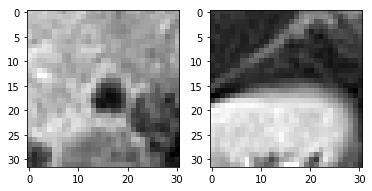

In [94]:
# can be used to determine if an image is flipped
cls = "colorectal"
acc_num = 'E101218384'#acc_nums[0]
img_fn = acc_num + ".npy"
img = np.load(C.full_img_dir+"\\"+cls + "\\"+img_fn)
hf.plot_slice_flips(img, voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"] == cls)].iloc[0], flipz="both", pad=10)
print(np.amin(img), np.amax(img), np.mean(img))
#hf.plot_section_auto(img)

In [153]:
vm.save_vois_as_imgs(cls="cholangio", save_dir="Z:\\Paper\\misclassified_lesions", normalize=True, acc_nums=["13003974_0"])

In [73]:
cbuild._plot_multich_with_bbox("E102095465_0.npy", save_dir="Z:\\Paper\\bad_lesions")

C:\Users\Clinton\AppData\Local\conda\conda\envs\medical-env\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [45]:
import importlib
importlib.reload(cbuild)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\python\\cnn_builder.py'>

-1.0007970709702931 1.0 -0.42795407389371615


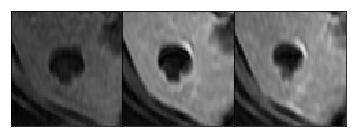

In [70]:
# Cropped, rescaled or augmented imgs
img = drm.plot_check("cyst", 2, C, "5465"+"_0")
print(np.amin(img), np.amax(img), np.mean(img))

## Run CNN

In [104]:
voi_df_art[voi_df_art['id'].str.contains('4340_0')]

,Filename,x1,x2,y1,y2,z1,z2,cls,flipz,real_dx,real_dy,real_dz,id,lesion_num


In [ ]:
import cnn_builder as cbuild
importlib.reload(cbuild)
cbuild.overnight_run(C)

# Situational

In [76]:
df = pd.read_excel(xls_name, sheetname)
df = drm.preprocess_df(df, C)
acc_nums = list(set(df['Patient E Number'].dropna().astype(str).tolist()))

In [ ]:
for img_fn in sorted(set(voi_df[voi_df["cls"] == "cyst"]['Filename'])):
    img = np.load("full_imgs\\"+img_fn)
    if np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,:img.shape[2]//3]) > \
            np.sum(img[img.shape[0]*1//5:img.shape[0]*4//5,img.shape[1]//5:img.shape[1]*2//5,(img.shape[2]+1)*2//3:]):
        print(img_fn)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" in img_fn:
            os.remove(C.aug_dir + cls + "\\" + img_fn)

img = img * 2 - 1

for cls in C.classes_to_include:
    fns = os.listdir(C.crops_dir + cls)
    for fn in fns:
        img = np.load(C.crops_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.crops_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.orig_dir + cls)
    for fn in fns:
        img = np.load(C.orig_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.orig_dir + cls + "\\" + fn, img)

for cls in C.classes_to_include:
    fns = os.listdir(C.aug_dir + cls)
    for fn in fns:
        img = np.load(C.aug_dir + cls + "\\" + fn)
        img = img * 2 - 1
        np.save(C.aug_dir + cls + "\\" + fn, img)

for cls in os.listdir(C.aug_dir):#classes_to_include:
    for img_fn in os.listdir(C.aug_dir + cls):
        if "refl" not in img_fn:
            img = np.load(C.aug_dir + cls + "\\" + img_fn)
            aug_img = tr.generate_reflected_img(img)
            np.save(C.aug_dir + cls + "\\" + img_fn[:-4] + "-refl", aug_img)